# OSMnx Intersection cleaning tuning

A sensitivity analysis of intersection simplification parameterisation undertaken for the Australian National Liveability Study 2018, in January 2019.

Updating in 2022 to examine implications for other settings, including Helsink, and noting that the OSMnx functionality may have changed, hence requiring code updates.

In [1]:
import osmnx as ox, matplotlib.pyplot as plt, numpy as np
import matplotlib.patches as patches
ox.settings.log_console=True
ox.settings.use_cache=True

%matplotlib inline

ox.__version__

'1.2.2'

In [2]:
# define pedestrian network custom filter (based on OSMnx 'walk' network type, without the cycling exclusion)
# copied code used in
# https://github.com/global-healthy-liveable-cities/global-indicators/blob/main/process/pre_process/_project_setup.py#L147 
# In previous code this lacked the initial '["highway"]' tag, as this used to be implicit in OSMnx, 
# but an update in 2019/20
pedestrian = (
             '["highway"]'
             '["area"!~"yes"]' 
             '["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]'
             '["foot"!~"no"]'  
             '["service"!~"private"]' 
             '["access"!~"private"]'
             )
             

In [3]:
def intersection_tuning(address, tolerance=[15,12,10,8,5], distance=750):
    # print(address)
    G = ox.graph_from_address(address, custom_filter= pedestrian, dist=distance)
    G_proj = ox.project_graph(G)
    g_proj_gdfs = ox.graph_to_gdfs(G_proj, nodes=False, edges=True, fill_edge_geometry=True)
    #itereate over cleaning buffer distance
    buffers = tolerance
    # instantiate plot
    fig, axarr = plt.subplots(ncols=5, sharex='col', sharey='row', squeeze=False, figsize=(18,4.5), dpi=80)
    for i in range(len(buffers)):
        # clean up the intersections and extract their xy coords
        ## Old approach:
        #intersections = ox.clean_intersections(G_proj, tolerance=buffers[i], dead_ends=False)
        intersections = ox.consolidate_intersections(G_proj, tolerance=buffers[i], rebuild_graph=False, dead_ends=False)
        points = np.array([point.xy for point in intersections])
        # plot the cleaned-up intersections
        g_proj_gdfs.plot(ax = axarr[0][i])
        axarr[0][i].scatter(x=points[:,0], y=points[:,1], s = 10, zorder=2, color=None, edgecolors='#000000')
        axarr[0][i].set_title("Tolerance: {}".format(buffers[i]))
        axarr[0][i].set_aspect(1)
        axarr[0][i].set_axis_off()
        # axarr[0][i].add_patch(patches.Rectangle((0.8, 0.8), 0.2, 0.2))
    plt.suptitle(address, fontsize=14, fontweight='bold')    
    plt.tight_layout()
    plt.show()
  

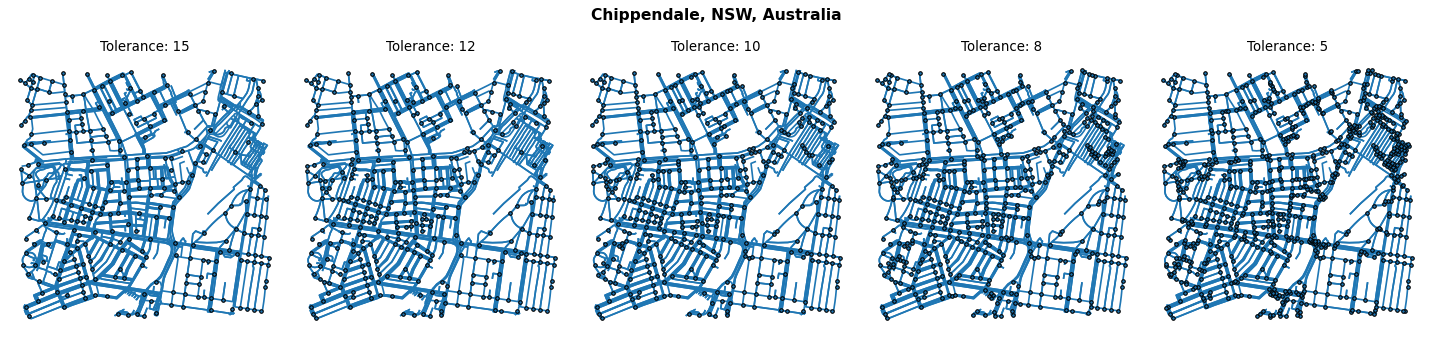

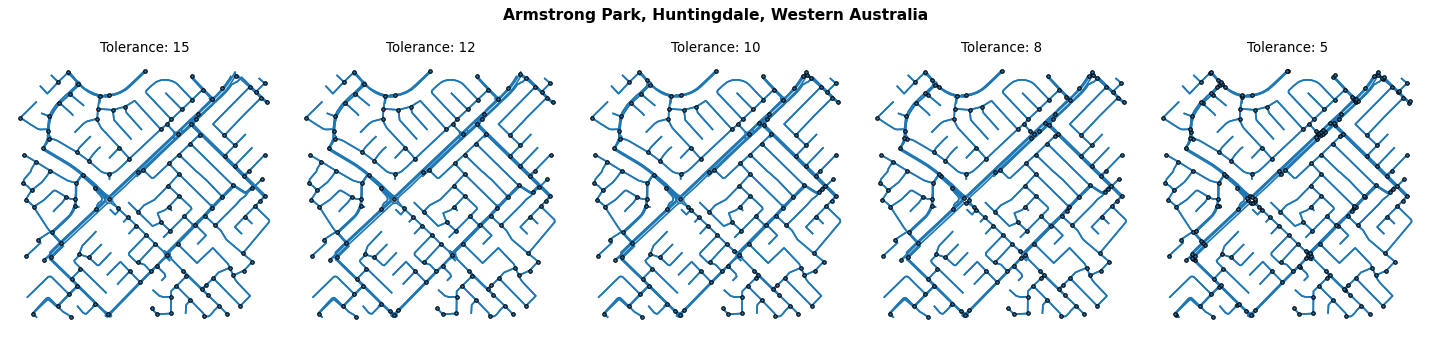

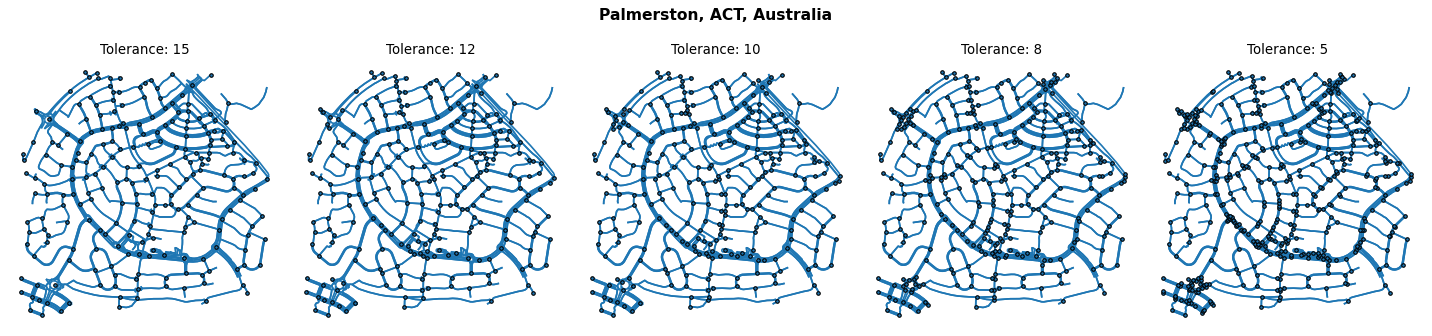

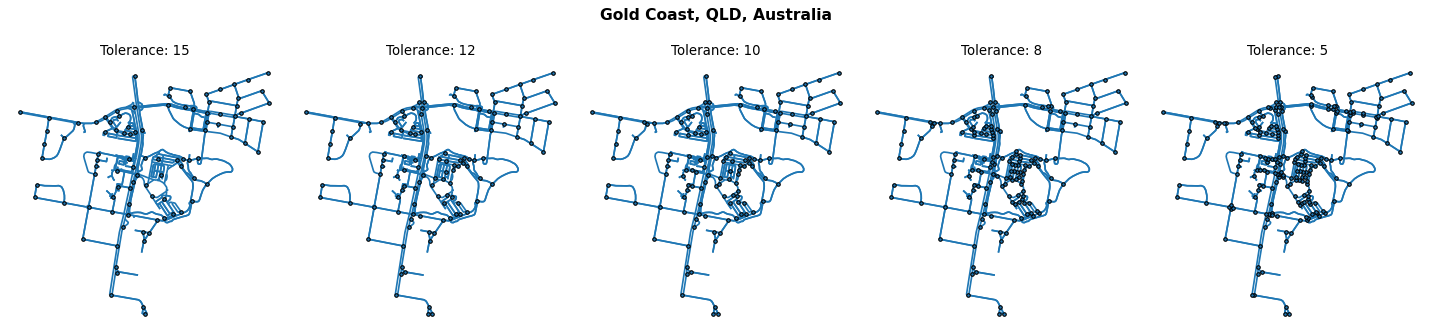

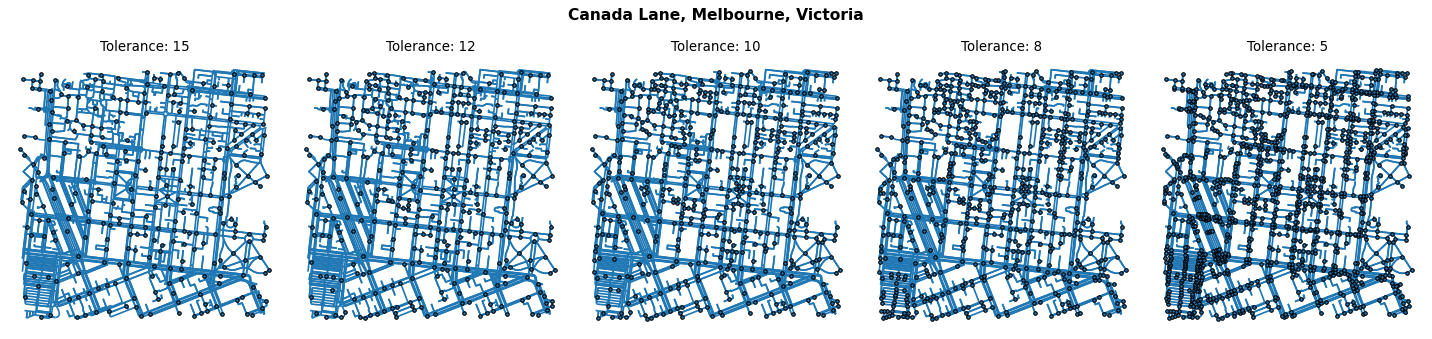

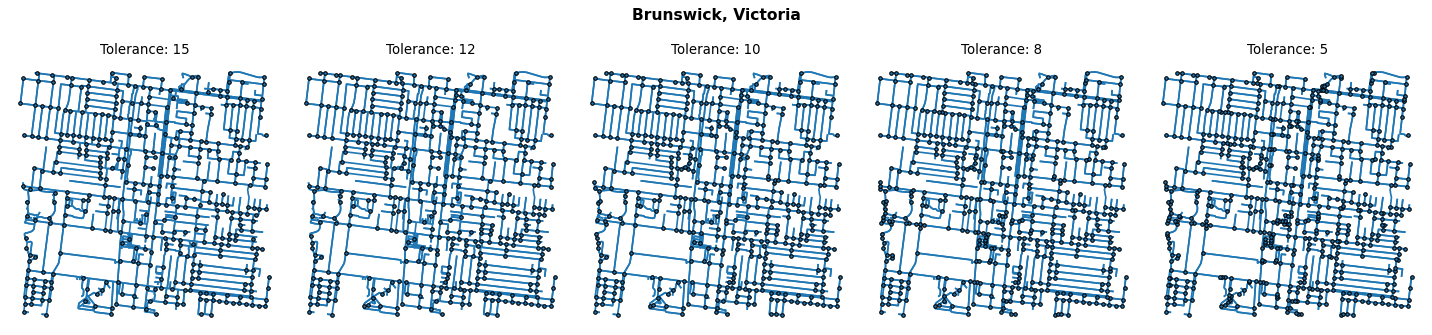

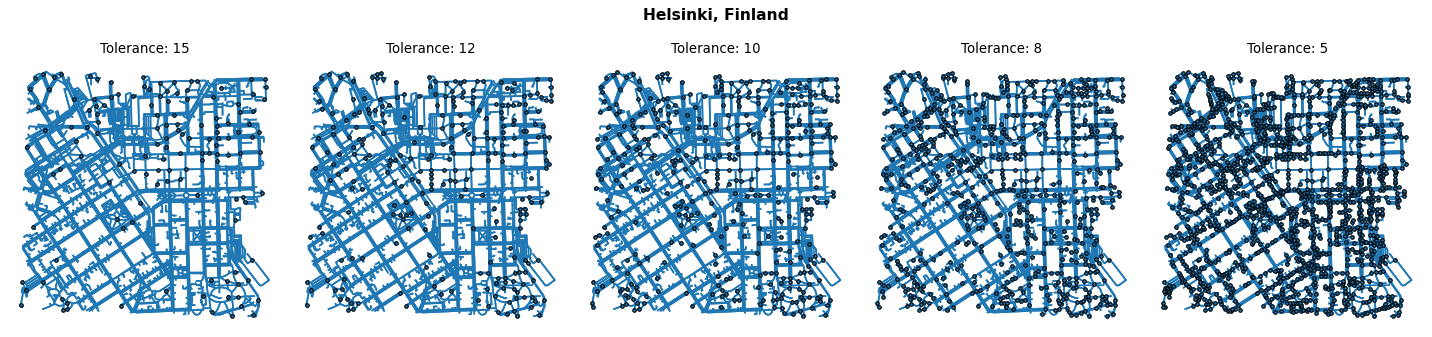

In [4]:
for address in [
                'Chippendale, NSW, Australia',
                'Armstrong Park, Huntingdale, Western Australia',
                'Palmerston, ACT, Australia',
                'Gold Coast, QLD, Australia',
                'Canada Lane, Melbourne, Victoria',
                'Brunswick, Victoria',
                'St Kilda, Victoria',
                'Helsinki, Finland',
               ]:
    intersection_tuning(address)

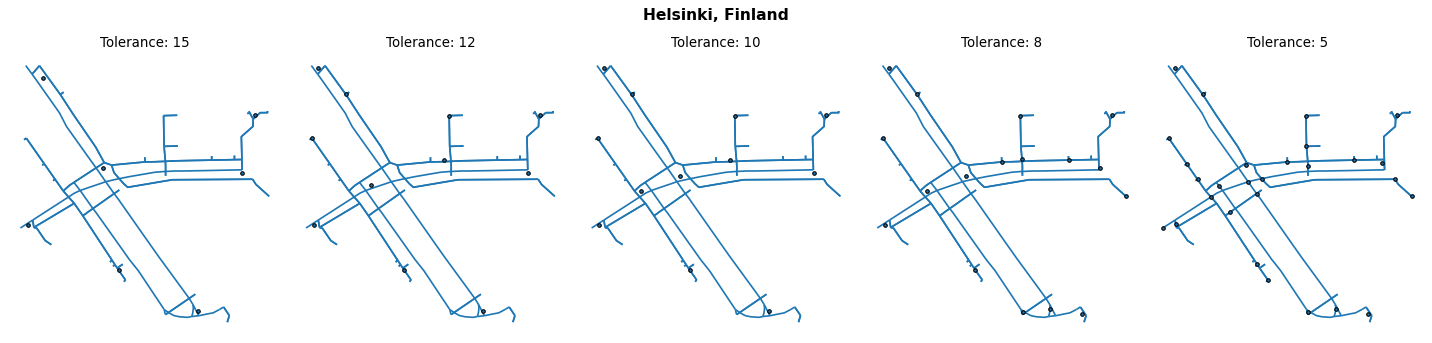

In [5]:
intersection_tuning('Helsinki, Finland',distance=100)

It is clear that the OSMnx consolidate intersections function is not adequately functioning with the identified network for Helsinki's CBD where many paths have been represented.  Some thought will be required how to account for this, because the result is clearly problematic: areas represented as having very dense pedestrian connectivity would result in an extreme under-estimation of true connectivity when calculation intersection density using the resulting data.  For this setting and using this network definition, a tolerance of 5m appears to work best.  The OSMnx default, for reference, is 10m.

I am not sure of the appropriate way forwards -- but while thinking about this is, it may help to consider maps of the above setting -- both using satellite imagery, and the OSM representation of connectivity:

https://www.google.com/maps/@60.167358,24.9448324,335m/data=!3m1!1e3
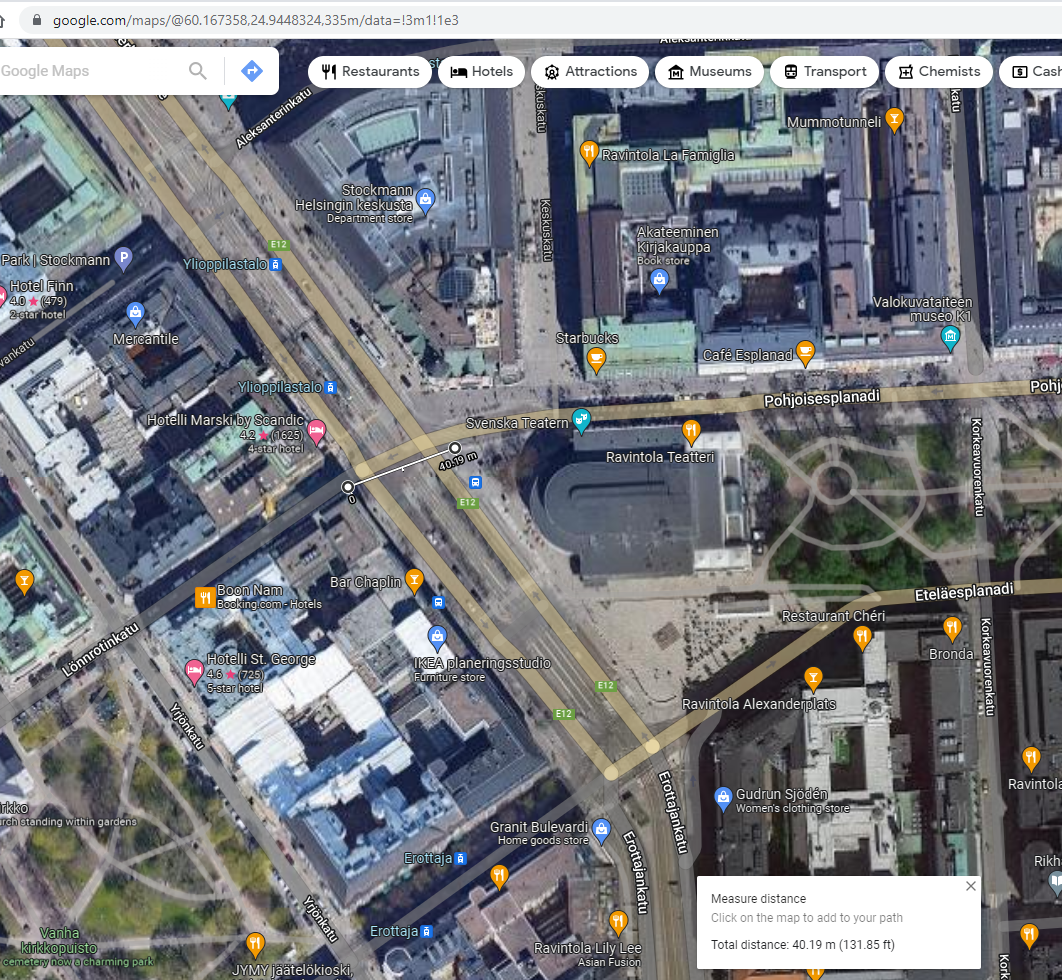

https://www.openstreetmap.org/query?lat=60.16706&lon=24.94281#map=17/60.16721/24.94318&layers=T
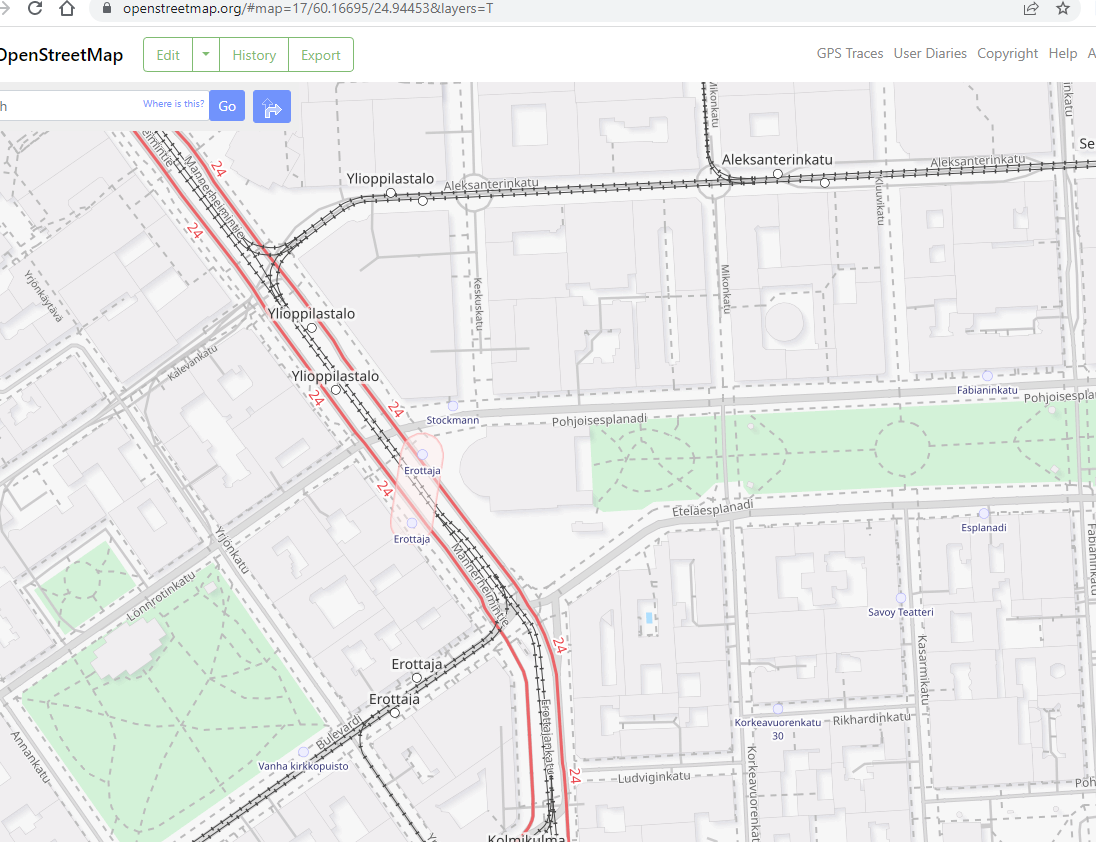


I don't believe the OSM image is displaying all the paths which are there ---for example, along Mannerheimintie which is about 40m wide, there appears to be 8 paths recorded, more or less every 5m.

It's actually quite a wide street (Google street view snippet below), and I suppose the paths are respective lanes of pedestrian/cyclist/vehicle traffice ---and because of the closeness of the paths recorded, it must trip up the consolidate intersections function.  For now, I'm not immediately sure how best to resolve this -- the consolidate intersections function works a bit differently to the older clean intersections function, although we have attempted to approximate its behaviour.  It will be worth doing a check to see how others are approaching this issue currently to decide how to move forwards.

https://www.google.com/maps/@60.1670092,24.9430692,3a,75y,346.19h,93.01t/data=!3m6!1e1!3m4!1sYKllPkctKKkJhQAjciPE6Q!2e0!7i13312!8i6656

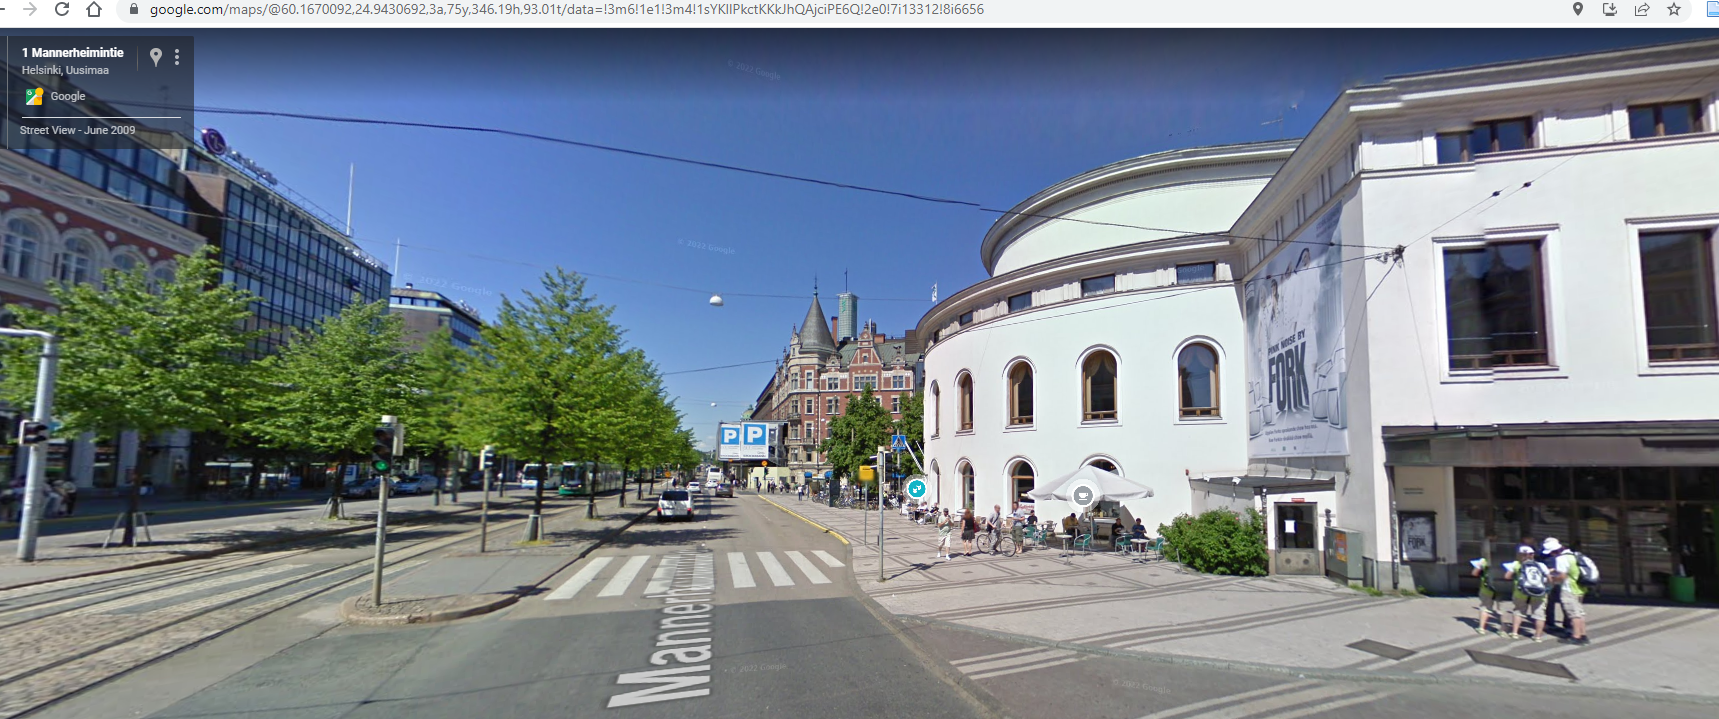

# Case studies for ntnl li data

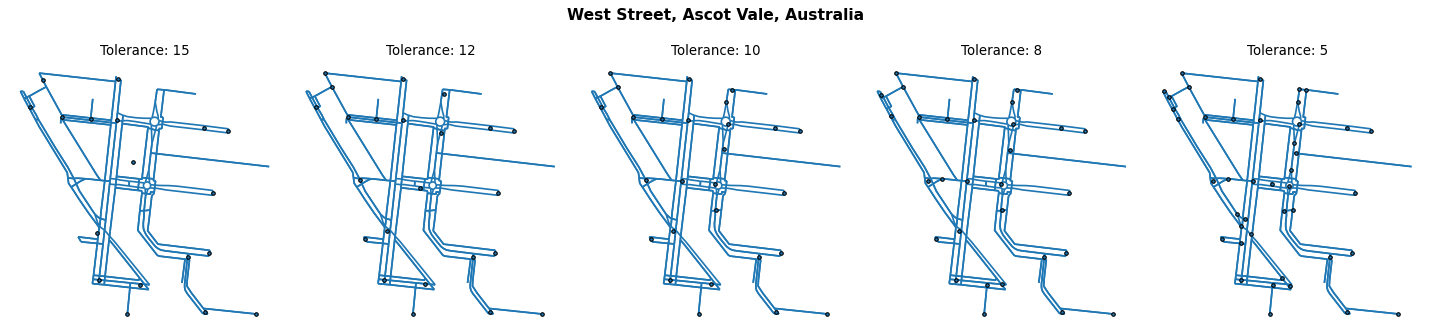

In [6]:
intersection_tuning('West Street, Ascot Vale, Australia',distance=200)